<a href="https://colab.research.google.com/github/Shumin326/SVM-Pegasos-Adagrad-and-CNN-/blob/master/SVMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
proj_root = '/content/gdrive/My Drive/ESE 545/proj2'
data_root = '/content/gdrive/My Drive/ESE 545/proj2/data'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import torchvision
from torchvision import datasets, transforms
import math

## Problem 1
- data preprocess
- data visualization

In [0]:
X_train_full = np.load(data_root+'/train.npy')
y_train_full = np.load(data_root+'/train_labels.npy')
X_test_full = np.load(data_root+'/test.npy')
y_test_full = np.load(data_root+'/test_labels.npy')

In [0]:
def dataprocess_bi(X_train,y_train,X_test, y_test):
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5]))
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5]))
    y_train[y_train==2] = 1
    y_train[y_train==5] = -1
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5]))
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5]))
    y_test[y_test==2] = 1
    y_test[y_test==5] = -1
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def dataprocess_tri(X_train,y_train,X_test, y_test):
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5],X_train[y_train==7]))
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5],y_train[y_train==7]))
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5],X_test[y_test==7]))
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5],y_test[y_test==7]))
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def visualization(X,y):
    # np.random.seed(100)
    X = X.reshape(len(X),28,28)
    p = np.random.randint(0,len(y),10)
    X_rand, y_rand = X[p], y[p]
    fig,ax =  plt.subplots(2,5,figsize = (8,8))
    for i in range(10):
        row = int(i/5)
        col = i-5*row
        ax[row][col].imshow(X_rand[i],cmap='gray', vmin=0, vmax=255)
        ax[row][col].set_title('class= '+str(y_rand[i]))
    plt.show()

In [0]:
# for problem 2, use two classes: 2&5
X_train, y_train, X_test, y_test = dataprocess_bi(X_train_full,y_train_full,X_test_full,y_test_full)

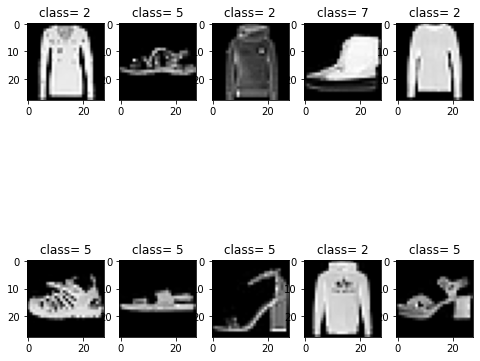

In [444]:
X_plt,y_plt,_,_ = dataprocess_tri(X_train_full,y_train_full,X_test_full,y_test_full)
visualization(X_plt,y_plt)

#Problem 2
- PEGASOS

In [0]:
def pegasos(X_train,y_train, X_test, y_test,B=20,lambda_=2):
    # lambda_: lambda_strongly_convex
    # B: batch size
    w = np.zeros(X_train.shape[1])  # initialize w
    err_train = []
    err_test = []
    for iteration in range(20):
        idx = np.random.randint(0,len(X_train),B)
        A_x = X_train[idx]
        A_y = y_train[idx]
        idx_sub = [i for i in range(B) if A_y[i]*w@A_x[i]<1]
        A_x_sub = A_x[idx_sub]
        A_y_sub = A_y[idx_sub]
        yita = 1/((t+1)*lambda_)
        delta_t = lambda_*w - yita/B*A_y_sub@A_x_sub
        w_ = w - yita*delta_t
        w = min(1,1/math.sqrt(lambda_)/math.sqrt(sum(w_**2)))*w_
        y_train_pred = np.sign(X_train@w)
        y_test_pred = np.sign(X_test@w)
        err_train.append(np.count_nonzero(y_train_pred!=y_train)/len(y_train))
        err_test.append(np.count_nonzero(y_test_pred!=y_test)/len(y_test))
    return err_train,err_test

In [0]:
def plots(err_train,err_test):
    plt.plot(np.arange(len(err_train)),err_train)
    plt.xlabel('iteration')
    plt.ylabel('error')
    plt.title("training error vs iteration")
    plt.show()
    plt.plot(np.arange(len(err_test)),err_test)
    plt.xlabel('iteration')
    plt.ylabel('error')
    plt.title('test error vs iteration')

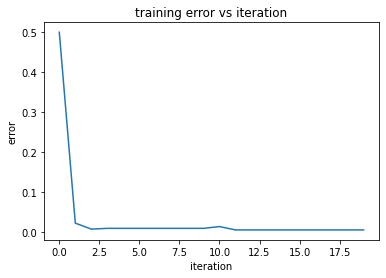

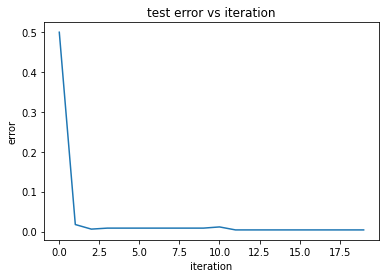

In [522]:
err_train,err_test = pegasos(X_train,y_train, X_test, y_test)
plots(err_train,err_test)

# Problem 3
- adagrad
- permutation needed

In [0]:
def diag_inv(G):
    diag = [1/G[i][i] for i in range(len(G))]
    G = np.zeros((len(G),len(G)))
    np.fill_diagonal(G,diag)
    return G

In [0]:
def updateG(G,xt,yt):
    diag = [math.sqrt((G[i,i])**2+(yt*xt[i])**2) for i in range(len(xt))]
    g = np.zeros((len(G),len(G)))
    np.fill_diagonal(g,diag)
    return g

In [0]:
def adagrad_svm(X_train,y_train,X_test,y_test):
    # G_diag = np.random.random_integers(1,size=X_train.shape[1])
    # G = np.zeros((X_train.shape[1],X_train.shape[1]))
    # np.fill_diagonal(G,G_diag)
    G = np.eye(X_train.shape[1])*100
    yita = 0.01
    w = np.zeros(X_train.shape[1])
    err_train = []
    err_test = []
    for t in range(100):
        if y_train[t]*(w@X_train[t])<1:
            deltaf = -y_train[t]*X_train[t]
        else:
            deltaf = np.zeros(X_train.shape[1])
        w -= yita*diag_inv(G)@deltaf
        G = updateG(G,X_train[t],y_train[t])
        y_train_pred = np.sign(X_train@w)
        y_test_pred = np.sign(X_test@w)
        err_train.append(np.count_nonzero(y_train_pred!=y_train)/len(y_train))
        err_test.append(np.count_nonzero(y_test_pred!=y_test)/len(y_test))
    return err_train, err_test

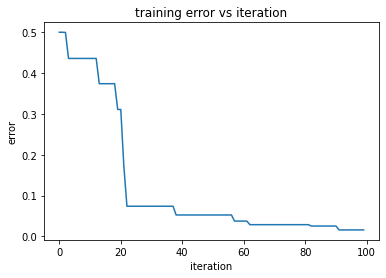

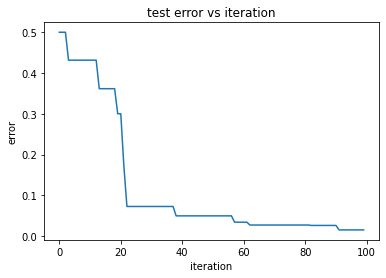

In [518]:
rand_idx = np.random.permutation(len(X_train))
X_train = X_train[rand_idx]
y_train = y_train[rand_idx]
err_train, err_test = adagrad_svm(X_train,y_train,X_test,y_test)
plots(err_train,err_test)

# problem 5